### IS backtest

#### Data Preprocessing

In [74]:
import os
import random
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import lunardate

from datetime import datetime,timedelta, timezone

In [75]:
def get_vn30f1m_trading(start, ticker):
    """
    Fetch VN30F1M trading data from the API.

    Parameters:
    start (int): The start timestamp.
    ticker (str): The ticker symbol.

    Returns:
    pd.DataFrame: A DataFrame containing the trading data.
    """
    end = '9999999999'
    url = f"https://services.entrade.com.vn/chart-api/chart?from={start}&resolution=1&symbol={ticker}&to={end}"
    try:
        resp = requests.get(url)
        data = resp.json()
        if not data:
            print(f"No data returned for {ticker}")
        vn30f1m = pd.DataFrame(data).iloc[:, :6]
        vn30f1m['t'] = vn30f1m['t'].astype(int).apply(lambda x: (datetime.fromtimestamp(x, timezone.utc) + timedelta(hours=7)).replace(tzinfo=None))
        vn30f1m.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
        return vn30f1m
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}.")
        return pd.DataFrame()

vn30f1m = get_vn30f1m_trading('0', 'VN30F1M')
vn30f1m

,date,open,high,low,close,volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361
...,...,...,...,...,...,...
331713,2024-08-07 14:27:00,1251.2,1251.9,1251.2,1251.7,1545
331714,2024-08-07 14:28:00,1251.9,1252.0,1251.7,1251.9,1453
331715,2024-08-07 14:29:00,1251.8,1251.8,1250.4,1250.4,2526
331716,2024-08-07 14:30:00,1251.0,1251.0,1251.0,1251.0,68


In [76]:
vn30f1m['date'] = pd.to_datetime(vn30f1m['date'])

morning_start = pd.to_datetime('09:00:00').time()
morning_end = pd.to_datetime('11:30:00').time()
afternoon_start = pd.to_datetime('13:00:00').time()
afternoon_end = pd.to_datetime('14:30:00').time()
extra_time = pd.to_datetime('14:45:00').time()

In [77]:
def get_vietnam_trading_days(start_date, end_date):
    # Tạo danh sách các ngày trong khoảng thời gian
    date_range = pd.date_range(start_date, end_date)

    # Loại bỏ các ngày cuối tuần (Thứ 7, Chủ nhật)
    trading_days = date_range[date_range.weekday < 5]

    # Lấy các năm trong khoảng thời gian
    years = list(set(date_range.year))

    all_holidays = []

    for year in years:
        # Danh sách các ngày lễ (dạng datetime)
        holidays = [
            datetime(year, 1, 1),  # Tết Dương lịch
            datetime(year, 4, 30),  # Ngày Giải phóng miền Nam
            datetime(year, 5, 1),  # Ngày Quốc tế Lao động
            datetime(year, 9, 2)  # Ngày Quốc khánh
        ]

        # Tính ngày Tết Nguyên Đán
        lunar_new_year = lunardate.LunarDate(year, 1, 1).toSolarDate()
        tet_holidays = [lunar_new_year + timedelta(days=i) for i in range(7)]  # Tết Nguyên Đán kéo dài 7 ngày
        holidays.extend(tet_holidays)

        # Tính ngày Giỗ tổ Hùng Vương (10 tháng 3 âm lịch)
        hung_vuong_anniversary = lunardate.LunarDate(year, 3, 10).toSolarDate()
        holidays.append(hung_vuong_anniversary)

        # Thêm các ngày lễ vào danh sách tổng
        all_holidays.extend(holidays)

    # Loại bỏ các ngày lễ khỏi danh sách ngày giao dịch
    trading_days = [day for day in trading_days if day not in all_holidays]

    return trading_days

In [78]:
def generate_trading_times(day):
    times = []
    current_time = pd.Timestamp.combine(day, morning_start)
    end_time = pd.Timestamp.combine(day, morning_end)
    while current_time <= end_time:
        times.append(current_time)
        current_time += pd.Timedelta(minutes=1)
        
    current_time = pd.Timestamp.combine(day, afternoon_start)
    end_time = pd.Timestamp.combine(day, afternoon_end)
    while current_time <= end_time:
        times.append(current_time)
        current_time += pd.Timedelta(minutes=1)
        
    times.append(pd.Timestamp.combine(day, extra_time))
    
    return times

In [79]:
start_date = vn30f1m['date'].min().date()
end_date = vn30f1m['date'].max().date()
trading_days = get_vietnam_trading_days(start_date, end_date)

full_range = []
for day in trading_days:
    full_range.extend(generate_trading_times(day))

In [80]:
full_range = pd.DatetimeIndex(full_range)
vn30f1m.set_index('date', inplace=True)
missing_times = full_range.difference(vn30f1m.index)
print(f"Missing timestamps: {missing_times}")

Missing timestamps: DatetimeIndex(['2018-08-13 14:45:00', '2018-08-28 09:26:00',
               '2018-08-28 09:29:00', '2018-08-28 09:51:00',
               '2018-08-29 10:00:00', '2018-09-03 09:00:00',
               '2018-09-03 09:01:00', '2018-09-03 09:02:00',
               '2018-09-03 09:03:00', '2018-09-03 09:04:00',
               ...
               '2024-04-29 14:22:00', '2024-04-29 14:23:00',
               '2024-04-29 14:24:00', '2024-04-29 14:25:00',
               '2024-04-29 14:26:00', '2024-04-29 14:27:00',
               '2024-04-29 14:28:00', '2024-04-29 14:29:00',
               '2024-04-29 14:30:00', '2024-04-29 14:45:00'],
              dtype='datetime64[ns]', length=44204, freq=None)


In [81]:
df_reindexed = vn30f1m.reindex(full_range)
vn30f1m = df_reindexed.ffill()
vn30f1m.index.name = 'date'
vn30f1m.reset_index(inplace=True)
vn30f1m

,date,open,high,low,close,volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...
375916,2024-08-07 14:27:00,1251.2,1251.9,1251.2,1251.7,1545.0
375917,2024-08-07 14:28:00,1251.9,1252.0,1251.7,1251.9,1453.0
375918,2024-08-07 14:29:00,1251.8,1251.8,1250.4,1250.4,2526.0
375919,2024-08-07 14:30:00,1251.0,1251.0,1251.0,1251.0,68.0


#### Extract only VN30F1M close price at 14pm

In [82]:
vn30f1m['date'] = pd.to_datetime(vn30f1m['date'])
vn30f1m = vn30f1m[vn30f1m['date'].dt.time == pd.to_datetime('14:00:00').time()]
vn30f1m = vn30f1m[['date', 'close']]
vn30f1m.set_index('date', inplace=True)
vn30f1m.index = vn30f1m.index.date
vn30f1m.index.name = 'date'
vn30f1m.dropna(inplace=True)
vn30f1m

,close
date,
2018-08-13,948.9
2018-08-14,959.1
2018-08-15,958.6
2018-08-16,943.1
2018-08-17,946.8
...,...
2024-08-01,1285.9
2024-08-02,1266.1
2024-08-05,1243.9


#### IS-OS split

In [83]:
vn30f1m_train = vn30f1m.iloc[:-504]
vn30f1m_test = vn30f1m.iloc[-504:]

#### Scraping HSI price data

In [84]:
import yfinance as yf
import pytz

ticker_list = ['^HSI']

ticker_intraday_prices = pd.DataFrame()
ticker_intraday_prices = {}

item = ticker_list[0]
print(f"Downloading data for: {item}")

download_data = yf.download(tickers=item, start='2018-08-13', end=datetime.now().strftime('%Y-%m-%d'))
download_data.index = pd.to_datetime(download_data.index)
download_data = download_data.reindex(vn30f1m.index)
download_data = download_data.ffill()

ticker_intraday_prices[item] = download_data

print(ticker_intraday_prices[item])
print(ticker_intraday_prices[item].shape)

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
date                                                                 
2018-08-13  27956.779297  28085.169922  27823.210938  27936.570312   
2018-08-14  27938.320312  27946.550781  27522.820312  27752.929688   
2018-08-15  27724.720703  27727.269531  27249.080078  27323.589844   
2018-08-16  26871.109375  27405.250000  26871.109375  27100.060547   
2018-08-17  27388.570312  27450.839844  27101.099609  27213.410156   
...                  ...           ...           ...           ...   
2024-08-01  17327.849609  17408.949219  17248.119141  17304.960938   
2024-08-02  17025.259766  17075.519531  16865.929688  16945.509766   
2024-08-05  16676.820312  16944.589844  16441.439453  16698.359375   
2024-08-06  16861.300781  16908.970703  16611.140625  16647.339844   
2024-08-07  16684.779297  16988.259766  16684.779297  16877.859375   

               Adj Close        Volume  
date                                    
2018-08

#### Extract HSI index close price 4pm (UTC)

In [85]:
hsi = ticker_intraday_prices[item]
hsi = hsi[['Close']]
hsi_train = hsi.iloc[:-504]
hsi_test = hsi.iloc[-504:]

#### Merge VN30F1M and HSI index price into one DataFrame

In [86]:
prices = pd.merge(vn30f1m_train, hsi_train, left_index=True, right_index=True, how = 'inner')
prices.rename(columns={'close': 'VN30F1M', 'Close': 'HSI'}, inplace=True)
prices.index.name = 'Date'
prices

,VN30F1M,HSI
Date,,
2018-08-13,948.9,27936.570312
2018-08-14,959.1,27752.929688
2018-08-15,958.6,27323.589844
2018-08-16,943.1,27100.060547
2018-08-17,946.8,27213.410156
...,...,...
2022-08-19,1283.0,19773.029297
2022-08-22,1273.6,19656.980469
2022-08-23,1268.7,19503.250000


#### Trading hypothesis
- Yesterday's price of HSI > The day before yesterday's price of HSI, enter long position for VN30F1m

- Yesterday's price of HSI < The day before yesterday's price of HSI, enter short position for VN30F1m

- Else: do nothing (no position opened/close position)

#### T-test ANOVA

- Null Hypothesis (H₀): There is no difference between the means of VN30F1M and HSI

- Alternative Hypothesis (H₁): There is a difference between the means of VN30F1M and HSI

Interpretation:

- If the p-value < 0.05, it rejects the null hypothesis. In other words, it indicates that the difference between the means of VN30F1M and HSI is statistically significant.

- If the p-value >= 0.05, you would fail to reject the null hypothesis, indicating that there is no significant difference between the means of VN30F1M and HSI.

In [87]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(prices['VN30F1M'], prices['HSI'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -309.20124896404144
P-value: 0.0


- There is a statistically significant difference between the mean values of VN30F1M and HSI.

- The VN30F1M and HSI series are not likely to have the same mean values

#### Correlation

By computing rolling correlations, we can observe how the relationship between **VN30F1M** and **HSI** changes over time. This can reveal patterns such as periods of high correlation (when they move closely together) or low correlation (when their movements diverge).

In [88]:
window_size = 30
results = []

for i in range(len(prices) - window_size + 1):
    window = prices.iloc[i:i + window_size]
    correlation_coef = window['VN30F1M'].corr(window['HSI'])
    results.append(correlation_coef)

results = pd.DataFrame(results, columns=['Rolling Correlation'])
print(results)

      Rolling Correlation
0                0.628661
1                0.603310
2                0.559129
3                0.553148
4                0.531675
...                   ...
1009            -0.804451
1010            -0.799150
1011            -0.777952
1012            -0.767415
1013            -0.742989

[1014 rows x 1 columns]


In [89]:
(results > 0).sum()

Rolling Correlation    745
dtype: int64

In [90]:
(results < 0).sum()

Rolling Correlation    269
dtype: int64

We have 1033 positive correlations and 318 negative correlations, the positive correlations do outnumber the negative correlations. This suggests that, overall, the assets tend to move ***in the same direction more frequently than in opposite directions***.

#### Trading strategy

In [91]:
def momentum_hsi(df):
    positions = []

    for i in range(2, len(df)):
        if df['HSI'].iloc[i - 1] > df['HSI'].iloc[i - 2]:
            positions.append(1)
        elif df['HSI'].iloc[i - 1] <= df['HSI'].iloc[i - 2]:
            positions.append(-1)
    
    positions.insert(0, 0)
    positions.insert(1, 0)
    df['Pos'] = positions
    return df

- If the current day's price is higher than the previous day's price, it suggests upward momentum, and the function appends 1 to the positions list.

- If the current day's price is lower than or equal to the previous day's price, it suggests downward or neutral momentum, and the function appends -1 to the positions list.

In [92]:
prices = momentum_hsi(prices)
prices

,VN30F1M,HSI,Pos
Date,,,
2018-08-13,948.9,27936.570312,0
2018-08-14,959.1,27752.929688,0
2018-08-15,958.6,27323.589844,-1
2018-08-16,943.1,27100.060547,-1
2018-08-17,946.8,27213.410156,-1
...,...,...,...
2022-08-19,1283.0,19773.029297,-1
2022-08-22,1273.6,19656.980469,1
2022-08-23,1268.7,19503.250000,-1


#### Vectorized PnL Backtest

In [93]:
def pnl(df):
    df['pnl'] = df['Pos'].shift() * (df['VN30F1M'] - df['VN30F1M'].shift())
    df['pnl'].iloc[0] = 0
    return df

In [94]:
prices = pnl(prices)
prices

<ipython-input-93-7cd7760709ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pnl'].iloc[0] = 0


,VN30F1M,HSI,Pos,pnl
Date,,,,
2018-08-13,948.9,27936.570312,0,0.0
2018-08-14,959.1,27752.929688,0,0.0
2018-08-15,958.6,27323.589844,-1,-0.0
2018-08-16,943.1,27100.060547,-1,15.5
2018-08-17,946.8,27213.410156,-1,-3.7
...,...,...,...,...
2022-08-19,1283.0,19773.029297,-1,-25.9
2022-08-22,1273.6,19656.980469,1,9.4
2022-08-23,1268.7,19503.250000,-1,-4.9


#### Performance metrics

In [95]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = running_max - cum_ret
    max_dd = (drawdown.max() / cum_ret.max()) * 100
    return sharpe, max_dd

In [96]:
sharpe, max_dd = perf_metrics(prices['pnl'])
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2f}%")

Sharpe ratio: 1.11
Max drawdown: 27.92%


## OOS backtest

In [97]:
prices = pd.merge(vn30f1m_test, hsi_test, left_index=True, right_index=True, how = 'inner')
prices.rename(columns={'close': 'VN30F1M', 'Close': 'HSI'}, inplace=True)
prices

,VN30F1M,HSI
date,,
2022-08-26,1295.0,20170.039062
2022-08-29,1274.0,20023.220703
2022-08-30,1281.5,19949.029297
2022-08-31,1293.0,19954.390625
2022-09-01,1293.9,19597.310547
...,...,...
2024-08-01,1285.9,17304.960938
2024-08-02,1266.1,16945.509766
2024-08-05,1243.9,16698.359375


In [98]:
prices = momentum_hsi(prices)
prices

,VN30F1M,HSI,Pos
date,,,
2022-08-26,1295.0,20170.039062,0
2022-08-29,1274.0,20023.220703,0
2022-08-30,1281.5,19949.029297,-1
2022-08-31,1293.0,19954.390625,-1
2022-09-01,1293.9,19597.310547,1
...,...,...,...
2024-08-01,1285.9,17304.960938,1
2024-08-02,1266.1,16945.509766,-1
2024-08-05,1243.9,16698.359375,-1


In [99]:
prices = pnl(prices)
prices

<ipython-input-93-7cd7760709ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pnl'].iloc[0] = 0


,VN30F1M,HSI,Pos,pnl
date,,,,
2022-08-26,1295.0,20170.039062,0,0.0
2022-08-29,1274.0,20023.220703,0,-0.0
2022-08-30,1281.5,19949.029297,-1,0.0
2022-08-31,1293.0,19954.390625,-1,-11.5
2022-09-01,1293.9,19597.310547,1,-0.9
...,...,...,...,...
2024-08-01,1285.9,17304.960938,1,12.3
2024-08-02,1266.1,16945.509766,-1,-19.8
2024-08-05,1243.9,16698.359375,-1,22.2


<Axes: xlabel='date'>

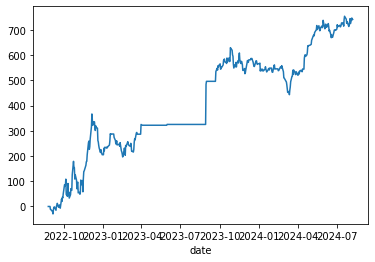

In [100]:
prices['pnl'].cumsum().plot()

In [101]:
sharpe, max_dd = perf_metrics(prices['pnl'])
print(f"Sharpe ratio: {sharpe}")
print(f"Max drawdown: {max_dd}")

Sharpe ratio: 1.4829225166371844
Max drawdown: 24.728044574157636
